## Практический кейс - анализ рекламных данных

### Предобработка данных и разведывательный анализ

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# 1. Получить статистику по дням.   
# 2. Просто посчитать число всех событий по дням, число показов, число кликов, число уникальных объявлений и уикльных компаний.   
# 3. Разобраться, почему случился такой скачок 2019-04-05? Каких событий стало больше? У всех объявлений или только у некоторых?   


# 4. Найти топ 10 объявлений по CTR за все время.   
#     CTR - это отношение всех просмотров объявления к кликам. 
#     Например, если у объявления было 100 показов и 2 клика, CTR = 0.02.
# 5. Различается ли средний и медианный CTR объявлений в наших данных?   


# 6. Похоже, в наших логах есть баг, объявления приходят с кликами, но без показов!   
# 7. Сколько таких объявлений, есть ли какие-то закономерности? Эта проблема наблюдается на всех платформах?   


# 8. Есть ли различия в CTR у объявлений с видео и без? А чему равняется 95 процентиль CTR по всем объявлениям за 2019-04-04?   


# 9. Для финансового отчета нужно рассчитать наш заработок по дням. В какой день мы заработали больше всего? В какой меньше? Мы списываем с клиентов деньги, если произошел клик по CPC объявлению, и мы списываем деньги за каждый показ CPM объявления, если у CPM объявления цена - 200 рублей, то за один показ мы зарабатываем 200 / 1000.   
# 10. Какая платформа самая популярная для размещения объявлений? Сколько процентов показов приходится на каждую из платформ (колонка platform)?   


# 11. А есть ли такие объявления, по которым сначала произошел клик, а только потом показ?

In [53]:
ads_data = pd.read_csv('data/ads_data.zip', compression='zip')

In [54]:
ads_data.head()

,ad_id,time,event,date,ad_cost_type,has_video,client_union_id,campaign_union_id,platform,ad_cost,target_audience_count,user_id
0,45061,1554076848,view,2019-04-01,CPM,0,34734,45061,android,200.6,1955269,9987
1,121288,1554076848,view,2019-04-01,CPM,0,121288,121288,web,187.4,232011,4039
2,102737,1554076863,view,2019-04-01,CPC,0,102535,102564,android,60.7,4410,4055
3,107564,1554076863,view,2019-04-01,CPM,0,106914,107564,android,217.3,62711,5582
4,4922,1554076869,view,2019-04-01,CPC,0,37,4400,android,60.1,1183501,2362


In [5]:
# данные из колонки time (время в формате - timestamp) и колонки date, для удобочитаемости
ads_data['full_date'] = pd.to_datetime(ads_data.time, unit='s')

In [6]:
# размерность таблицы
ads_data.shape

(1000000, 13)

In [7]:
ads_data.dtypes

ad_id                             int64
time                              int64
event                            object
date                             object
ad_cost_type                     object
has_video                         int64
client_union_id                   int64
campaign_union_id                 int64
platform                         object
ad_cost                         float64
target_audience_count             int64
user_id                           int64
full_date                datetime64[ns]
dtype: object

In [8]:
# date из строки в дату
ads_data['date'] = pd.to_datetime(ads_data.date)

In [9]:
ads_data.dtypes

ad_id                             int64
time                              int64
event                            object
date                     datetime64[ns]
ad_cost_type                     object
has_video                         int64
client_union_id                   int64
campaign_union_id                 int64
platform                         object
ad_cost                         float64
target_audience_count             int64
user_id                           int64
full_date                datetime64[ns]
dtype: object

In [10]:
ads_data.head()

,ad_id,time,event,date,ad_cost_type,has_video,client_union_id,campaign_union_id,platform,ad_cost,target_audience_count,user_id,full_date
0,45061,1554076848,view,2019-04-01,CPM,0,34734,45061,android,200.6,1955269,9987,2019-04-01 00:00:48
1,121288,1554076848,view,2019-04-01,CPM,0,121288,121288,web,187.4,232011,4039,2019-04-01 00:00:48
2,102737,1554076863,view,2019-04-01,CPC,0,102535,102564,android,60.7,4410,4055,2019-04-01 00:01:03
3,107564,1554076863,view,2019-04-01,CPM,0,106914,107564,android,217.3,62711,5582,2019-04-01 00:01:03
4,4922,1554076869,view,2019-04-01,CPC,0,37,4400,android,60.1,1183501,2362,2019-04-01 00:01:09


<Axes: xlabel='date'>

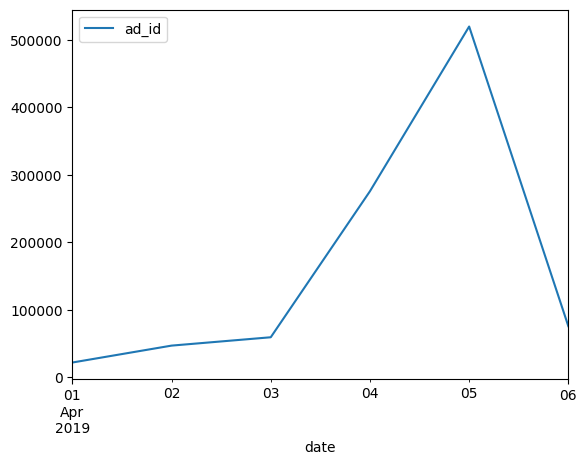

In [11]:
# Получить статистику по дням
ads_data.groupby('date') \
    .agg({'ad_id': 'count'}).plot()

In [12]:
# посчитать число всех событий по дням, число показов, число кликов
ads_data.groupby(['date', 'event'], as_index=False) \
    .agg({'ad_id': 'count'}) \
    .pivot(index='date', columns='event', values='ad_id').reset_index() \
    .fillna(0)  # важно! если нет кликов/показов — будет NaN

event,date,click,view
0,2019-04-01,291,21782
1,2019-04-02,545,46572
2,2019-04-03,460,59023
3,2019-04-04,643,275092
4,2019-04-05,92321,427386
5,2019-04-06,14918,60967


In [13]:
# число уникальных объявлений и уникальных компаний
ads_data.groupby('date', as_index=False) \
    .agg({'ad_id': 'nunique', 'client_union_id': 'nunique'}).reset_index()

,index,date,ad_id,client_union_id
0,0,2019-04-01,150,146
1,1,2019-04-02,344,326
2,2,2019-04-03,360,335
3,3,2019-04-04,407,383
4,4,2019-04-05,465,420
5,5,2019-04-06,220,204


In [14]:
# Разобраться, почему случился такой скачок 2019-04-05? Каких событий стало больше? У всех объявлений или только у некоторых?
ads_data[ads_data.date == '2019-04-05'] \
    .groupby('ad_id', as_index=False) \
    .agg({'time': 'count'}) \
    .sort_values('time', ascending=False) \
    .head()

,ad_id,time
397,112583,393828
367,107729,29745
125,28142,20903
198,38892,8437
369,107837,8341


In [15]:
ad_id = 112583
ads_data.query('ad_id == @ad_id') \
    .groupby('date', as_index=False) \
    .agg({'time': 'count'})


,date,time
0,2019-04-05,393828
1,2019-04-06,63741


### Рассчитываем CTR

In [16]:
# Найти топ 10 объявлений по CTR за все время. CTR - это отношение всех просмотров объявления к кликам. 
# Например, если у объявления было 100 показов и 2 клика, CTR = 0.02.

# Найти топ 10 объявлений по CTR за все время.
ads_data_by_ad = ads_data.groupby(['ad_id', 'event'], as_index=False) \
    .agg({'time': 'count'}) \
    .pivot(index='ad_id', columns='event', values='time').reset_index()

In [17]:
ads_data_by_ad = ads_data_by_ad.assign(ctr = ads_data_by_ad.click / ads_data_by_ad.view,
                        ctr_per = (ads_data_by_ad.click / ads_data_by_ad.view * 100))

In [18]:
ads_data_by_ad.sort_values('ctr', ascending=False).head(10)

event,ad_id,click,view,ctr,ctr_per
873,117164,6.0,19.0,0.315789,31.578947
787,112583,105767.0,351802.0,0.300644,30.064354
463,42507,3.0,11.0,0.272727,27.272727
665,98569,3.0,16.0,0.187500,18.750000
621,46639,44.0,253.0,0.173913,17.391304
174,23599,4.0,24.0,0.166667,16.666667
126,19912,4.0,25.0,0.160000,16.000000
756,110414,5.0,32.0,0.156250,15.625000
593,45969,2.0,13.0,0.153846,15.384615
136,20662,4.0,26.0,0.153846,15.384615


In [19]:
# Различается ли средний и медианный CTR объявлений в наших данных?
ads_data_by_ad.ctr.mean()

np.float64(0.029341727343227063)

In [20]:
ads_data_by_ad.ctr.median()

np.float64(0.018265221017514596)

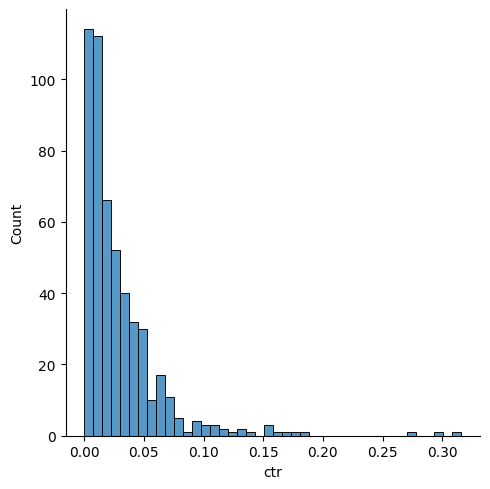

In [21]:
sns.displot(ads_data_by_ad.ctr, kde=False)

### Ищем баги в аналитических логах

In [22]:
# Похоже, в наших логах есть баг, объявления приходят с кликами, но без показов!
# Сколько таких объявлений, есть ли какие-то закономерности? Эта проблема наблюдается на всех платформах?

ads_data_by_ad = ads_data_by_ad.fillna(0)

In [23]:
ads_ids_bug = ads_data_by_ad.query('click == 0').ad_id

In [24]:
ads_data[ads_data.ad_id.isin(ads_ids_bug)] \
    .groupby('platform', as_index=False) \
    .agg({'ad_id': 'count'}) \
    .sort_values('ad_id')

,platform,ad_id
2,web,9263
1,ios,14187
0,android,23099


In [25]:
ads_data \
    .groupby('platform', as_index=False) \
    .agg({'ad_id': 'count'}) \
    .sort_values('ad_id')

,platform,ad_id
2,web,199665
1,ios,299979
0,android,500356


### Процентили и медиана распределения

In [26]:
# А чему равняется 95 процентиль CTR по всем объявлениям за 2019-04-04?
df_2019_04_04 = ads_data[ads_data.date == '2019-04-04'].groupby(['ad_id', 'event'], as_index=False) \
    .agg({'time': 'count'}) \
    .pivot(index='ad_id', columns='event', values='time').reset_index() \
    .fillna(0)

In [27]:
df_2019_04_04['ctr'] = df_2019_04_04.click / df_2019_04_04.view

In [28]:
ctr_all = df_2019_04_04[df_2019_04_04.click > 0].ctr.quantile(q=0.95)

In [29]:
print(f"95-й процентиль CTR:    {ctr_all:.4%}")

95-й процентиль CTR:    16.6667%


In [30]:
# Есть ли различия в CTR у объявлений с видео и без?
ctr_video = ads_data[ads_data.date == '2019-04-04'].groupby(['ad_id', 'has_video', 'event'], as_index=False) \
    .agg({'time': 'count'}) \
    .pivot(index=['ad_id', 'has_video'], columns='event', values='time').reset_index() \
    .fillna(0)

In [31]:
ctr_video['ctr'] = ctr_video.click / ctr_video.view

In [32]:
with_clicks = ctr_video[ctr_video.click > 0]

In [33]:
ctr_with_video = with_clicks[with_clicks['has_video'] == True]['ctr'].quantile(0.95)
ctr_without_video = with_clicks[with_clicks['has_video'] == False]['ctr'].quantile(0.95)

In [34]:
print(f"95-й процентиль CTR (с видео):    {ctr_with_video:.4%}")
print(f"95-й процентиль CTR (без видео):  {ctr_without_video:.4%}")

95-й процентиль CTR (с видео):    5.9028%
95-й процентиль CTR (без видео):  16.6667%


### Составные запросы при фильтрации данных

In [35]:
# Для финансового отчета нужно рассчитать наш заработок по дням.
# В какой день мы заработали больше всего? В какой меньше?
# Мы списываем с клиентов деньги, если произошел клик по CPC объявлению,
# и мы списываем деньги за каждый показ CPM объявления,
# если у CPM объявления цена - 200 рублей, то за один показ мы зарабатываем 200 / 1000.   
# Какая платформа самая популярная для размещения объявлений?
# Сколько процентов показов приходится на каждую из платформ (колонка platform)?

ads_data.head()

,ad_id,time,event,date,ad_cost_type,has_video,client_union_id,campaign_union_id,platform,ad_cost,target_audience_count,user_id,full_date
0,45061,1554076848,view,2019-04-01,CPM,0,34734,45061,android,200.6,1955269,9987,2019-04-01 00:00:48
1,121288,1554076848,view,2019-04-01,CPM,0,121288,121288,web,187.4,232011,4039,2019-04-01 00:00:48
2,102737,1554076863,view,2019-04-01,CPC,0,102535,102564,android,60.7,4410,4055,2019-04-01 00:01:03
3,107564,1554076863,view,2019-04-01,CPM,0,106914,107564,android,217.3,62711,5582,2019-04-01 00:01:03
4,4922,1554076869,view,2019-04-01,CPC,0,37,4400,android,60.1,1183501,2362,2019-04-01 00:01:09


Для финансового отчета нужно рассчитать наш заработок по дням.

In [36]:
# 1. Рассчитываем заработок по каждой строке
revenue = ads_data.copy()

In [37]:
# CPC: только клики
revenue['revenue_cpc'] = 0.0
revenue.loc[(revenue['ad_cost_type'] == 'CPC') & (revenue['event'] == 'click'), 'revenue_cpc'] = \
    revenue['ad_cost']

In [38]:
# CPM: за каждый показ
revenue['revenue_cpm'] = 0.0
revenue.loc[(revenue['ad_cost_type'] == 'CPM') & (revenue['event'] == 'view'), 'revenue_cpm'] = \
    revenue['ad_cost'] / 1000

In [39]:
# Общий заработок
revenue['revenue'] = revenue['revenue_cpc'] + revenue['revenue_cpm']

In [40]:
# 2. Заработок по дням
daily_revenue = revenue.groupby('date')['revenue'].sum().round(2).reset_index()
daily_revenue.columns = ['date', 'total_revenue']

print("Заработок по дням:")
print(daily_revenue)

Заработок по дням:
        date  total_revenue
0 2019-04-01        6655.71
1 2019-04-02       13285.79
2 2019-04-03       14145.96
3 2019-04-04       54988.80
4 2019-04-05       96123.12
5 2019-04-06       13346.93


В какой день мы заработали больше всего? В какой меньше?

In [41]:
max_day = daily_revenue.loc[daily_revenue['total_revenue'].idxmax()]
min_day = daily_revenue.loc[daily_revenue['total_revenue'].idxmin()]

print(f"\nМаксимум заработка: {max_day['date']} — {max_day['total_revenue']:,.2f} руб.")
print(f"Минимум заработка:  {min_day['date']} — {min_day['total_revenue']:,.2f} руб.")


Максимум заработка: 2019-04-05 00:00:00 — 96,123.12 руб.
Минимум заработка:  2019-04-01 00:00:00 — 6,655.71 руб.


Какая платформа самая популярная для размещения объявлений?   
Сколько процентов показов приходится на каждую из платформ (колонка platform)?

In [42]:
# Только показы
views = ads_data[ads_data['event'] == 'view']

In [43]:
# Количество показов по платформам
platform_views = views.groupby('platform').size().reset_index(name='impressions')
total_impressions = platform_views['impressions'].sum()

In [44]:
# Проценты
platform_views['percentage'] = (platform_views['impressions'] / total_impressions * 100).round(2)

In [45]:
# Сортировка
platform_views = platform_views.sort_values('impressions', ascending=False).reset_index(drop=True)

print("\nПоказы по платформам:")
print(platform_views)


Показы по платформам:
  platform  impressions  percentage
0  android       445722       50.03
1      ios       267117       29.99
2      web       177983       19.98


In [46]:
# Добавим колонку с подписями
platform_views['label'] = platform_views['platform'] + ' (' + platform_views['percentage'].astype(str) + '%)'

print(platform_views)

  platform  impressions  percentage             label
0  android       445722       50.03  android (50.03%)
1      ios       267117       29.99      ios (29.99%)
2      web       177983       19.98      web (19.98%)


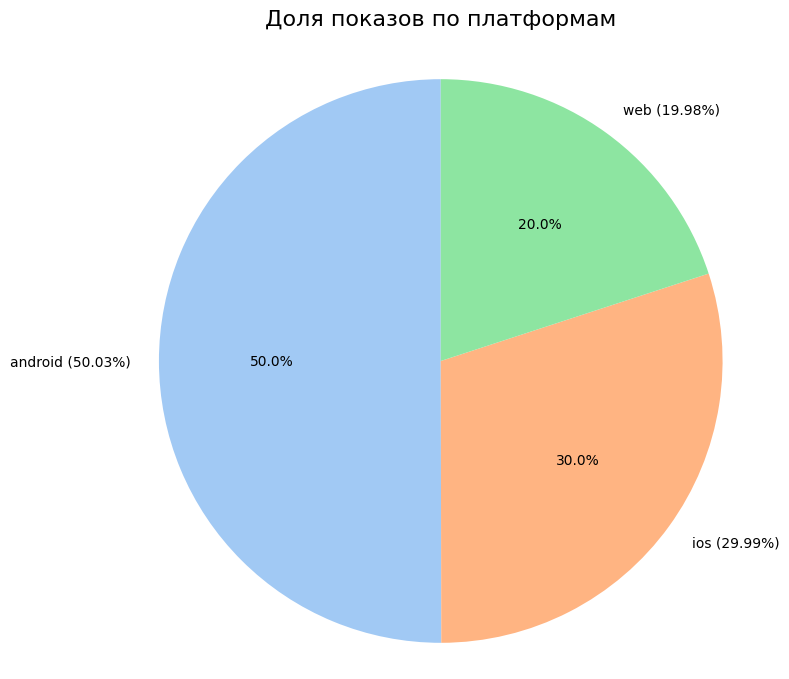

In [47]:
# Круговая диаграмма (pie chart) - лучше всего для долей
plt.figure(figsize=(8, 8))
plt.pie(
    platform_views['percentage'],
    labels=platform_views['label'],
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('pastel')
)
plt.title('Доля показов по платформам', fontsize=16, pad=20)
plt.axis('equal')  # круг
plt.show()

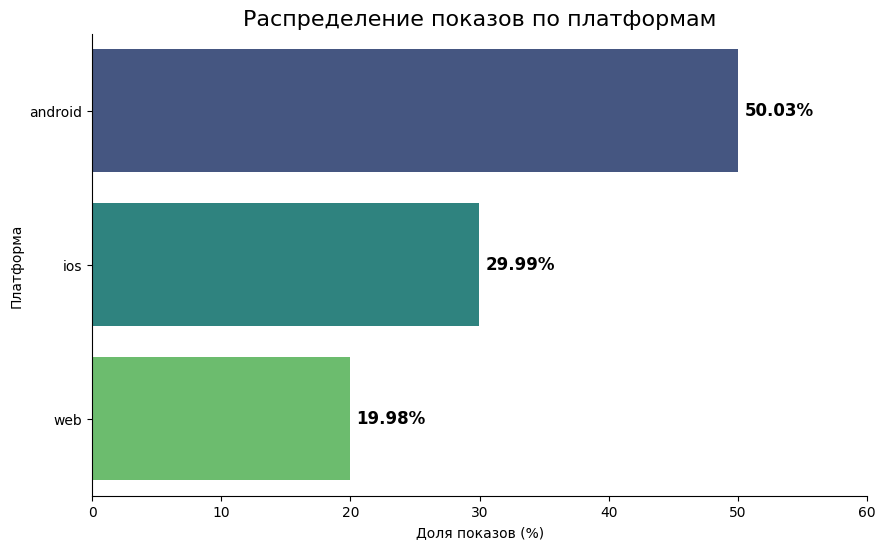

In [48]:
# Горизонтальная столбчатая диаграмма — для отчёта
plt.figure(figsize=(10, 6))
sns.barplot(
    data=platform_views,
    y='platform',
    x='percentage',
    hue='platform',
    palette='viridis',
    legend=False
)

# Подписи на столбцах
for i, row in platform_views.iterrows():
    plt.text(row['percentage'] + 0.5, i, f"{row['percentage']}%", 
            va='center', fontsize=12, fontweight='bold')

plt.xlabel('Доля показов (%)')
plt.ylabel('Платформа')
plt.title('Распределение показов по платформам', fontsize=16)
plt.xlim(0, platform_views['percentage'].max() + 10)
sns.despine()
plt.show()

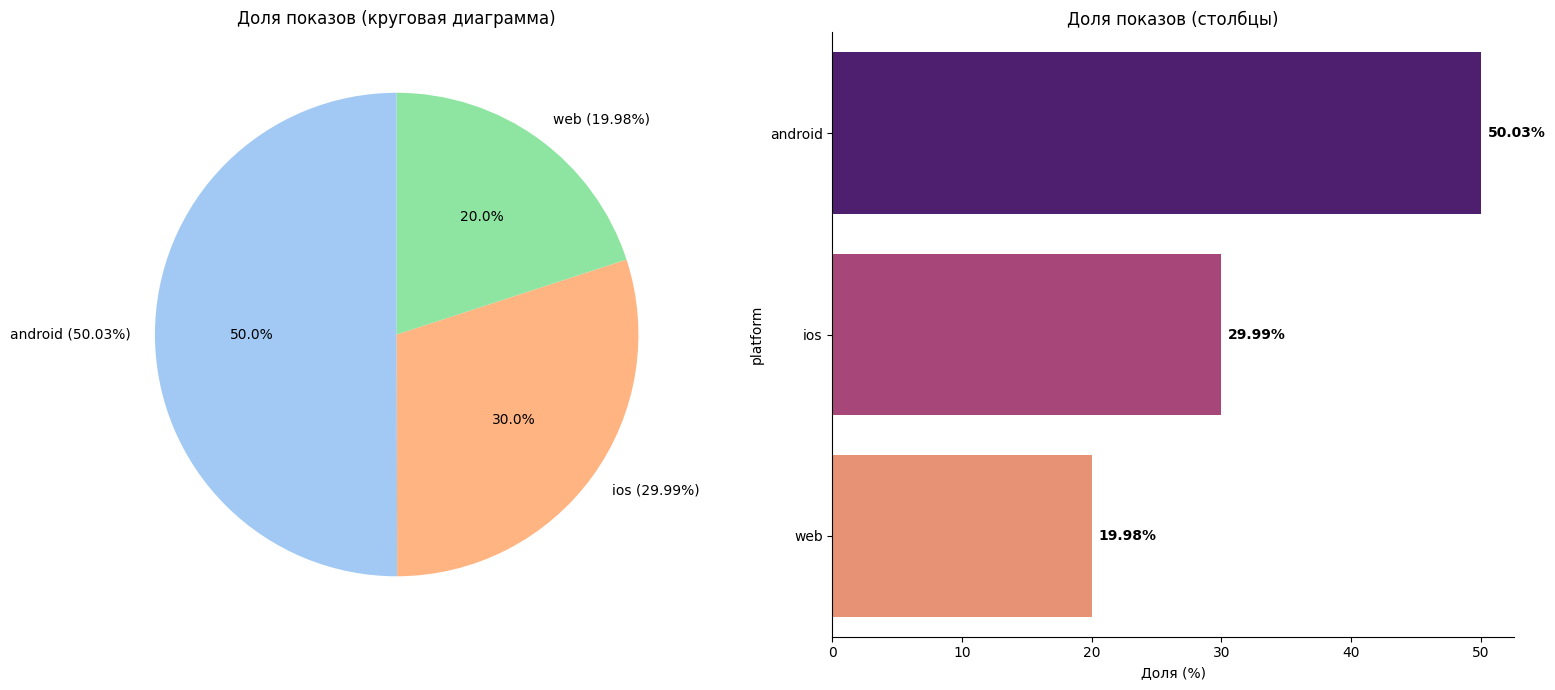

In [49]:
# Комбинированный график (pie + bar)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Круговая
ax1.pie(platform_views['percentage'], labels=platform_views['label'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
ax1.set_title('Доля показов (круговая диаграмма)')

# Столбчатая
sns.barplot(
    data=platform_views,
    y='platform',
    x='percentage',
    hue='platform',
    ax=ax2,
    palette='magma',
    legend=False,)

for i, row in platform_views.iterrows():
    ax2.text(row['percentage'] + 0.5, i, f"{row['percentage']}%", va='center', fontweight='bold')
    
ax2.set_xlabel('Доля (%)')
ax2.set_title('Доля показов (столбцы)')
sns.despine()

plt.tight_layout()
plt.show()

In [50]:
# Самая популярная
top_platform = platform_views.iloc[0]
print(f"\nСамая популярная платформа: {top_platform['platform']} "
    f"({top_platform['impressions']:,} показов, {top_platform['percentage']}%)")


Самая популярная платформа: android (445,722 показов, 50.03%)


In [51]:
# А есть ли такие объявления, по которым сначала произошел клик, а только потом показ?
ads_data.groupby(['ad_id', 'event'], as_index=False) \
    .agg({'time': 'min'}) \
    .pivot(index='ad_id', columns='event', values='time').reset_index() \
    .query('click < view')

event,ad_id,click,view
115,18681,1.554424e+09,1.554432e+09
174,23599,1.554423e+09,1.554443e+09
281,32386,1.554250e+09,1.554250e+09
285,33033,1.554423e+09,1.554435e+09
329,36758,1.554341e+09,1.554341e+09
359,38224,1.554336e+09,1.554337e+09
522,44283,1.554337e+09,1.554337e+09
539,44766,1.554426e+09,1.554430e+09
621,46639,1.554163e+09,1.554163e+09
665,98569,1.554347e+09,1.554364e+09


In [52]:
ads_data[ads_data.ad_id == 18681].sort_values('time')

,ad_id,time,event,date,ad_cost_type,has_video,client_union_id,campaign_union_id,platform,ad_cost,target_audience_count,user_id,full_date
124062,18681,1554423500,click,2019-04-05,CPM,0,1575,18539,android,194.1,8093,2041,2019-04-05 00:18:20
141073,18681,1554432335,view,2019-04-05,CPM,0,1575,18539,web,194.1,8093,8610,2019-04-05 02:45:35
160090,18681,1554443169,view,2019-04-05,CPM,0,1575,18539,android,194.1,8093,8220,2019-04-05 05:46:09
190004,18681,1554449958,view,2019-04-05,CPM,0,1575,18539,ios,194.1,8093,2999,2019-04-05 07:39:18
225364,18681,1554451596,view,2019-04-05,CPM,0,1575,18539,android,194.1,8093,2157,2019-04-05 08:06:36
235428,18681,1554453021,view,2019-04-05,CPM,0,1575,18539,android,194.1,8093,9094,2019-04-05 08:30:21
276971,18681,1554453798,view,2019-04-05,CPM,0,1575,18539,android,194.1,8093,8864,2019-04-05 08:43:18
290399,18681,1554455548,view,2019-04-05,CPM,0,1575,18539,ios,194.1,8093,428,2019-04-05 09:12:28
300935,18681,1554456931,view,2019-04-05,CPM,0,1575,18539,android,194.1,8093,3046,2019-04-05 09:35:31
338678,18681,1554462561,view,2019-04-05,CPM,0,1575,18539,ios,194.1,8093,8607,2019-04-05 11:09:21
